### simple simulation - no transaction fee, no etf expenses, no taxes, no dividends

# 초기 조건 / 데이터 임포트 / 벤치마크 계산

## 라이브러리 임포트 / 초기 조건 설정

In [409]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [410]:
import pandas as pd
import numpy as np
from datetime import datetime
import math

In [411]:
transaction_fee = 0
etf_expenses = 0
tax_rate = 0
initial_cash = 10000

In [412]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [413]:
strategies = []
returns = []

## 데이터 임포트

In [414]:
df = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')[:-2] # 2021-09까지 결과 출력
closes = df.Close.to_numpy()
opens = df.Open.to_numpy()

In [415]:
tb3_df = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/TB3MS.csv')
risk_free_rates = tb3_df.TB3MS.to_numpy() / 100

## 벤치마크 계산

In [416]:
benchmark_shares = initial_cash // closes[0]
benchmark = closes * benchmark_shares

In [417]:
# 출처: http://blog.quantylab.com/mdd.html
def get_mdd(x):
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return peak_upper, peak_lower, (arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]

In [418]:
get_mdd(benchmark)

(176, 192, -0.5219527780906348)

In [419]:
def annualize(closes, opens, month_lag):
  annual_returns = []
  for i in range(len(closes) // 12 +1):
    if (i+1)*12 > len(closes):
      annual_returns.append(round((closes[-1] - opens[i*12-month_lag]) / opens[i*12-month_lag],4))
    elif i*12-month_lag < 0:
      annual_returns.append(round((closes[i*12+11-month_lag] - opens[0]) / opens[0], 4))
    else:
      annual_returns.append(round((closes[i*12+11-month_lag] - opens[i*12-month_lag]) / opens[i*12-month_lag],4))
  return annual_returns

In [420]:
def statistics(name, closes, annual_returns, current_flag=False):
  mean_risk_free_rate = np.mean(risk_free_rates) if current_flag else 0.005
  cagr = round(pow(closes[-1] / closes[0], 1/ (round(len(closes) / 12))) - 1, 4)
  mean_annual = round(np.mean(annual_returns),4)
  stddev = round(np.std(annual_returns),4)
  sharpe = round((np.mean(annual_returns)- mean_risk_free_rate) / np.std(annual_returns),4)
  worst_year = round(min(annual_returns), 4)
  best_year = round(max(annual_returns), 4)
  mdd = round(get_mdd(closes)[2], 4)
  return {'name':name, 'initial_balance': round(closes[0], 2), 'final_balance':round(closes[-1],2), 'cagr':cagr, 'mean_annual':mean_annual, 'stddev':stddev, 'sharpe':sharpe, 'worst_year':worst_year, 'best_year': best_year, 'mdd': mdd}

In [421]:
strategies.append(statistics('Benchmark', benchmark, annualize(closes, opens, 1)))
returns.append({"name":'Benchmark', "df":benchmark})

In [422]:
strategies

[{'best_year': 0.3453,
  'cagr': 0.0814,
  'final_balance': 96556.5,
  'initial_balance': 9991.41,
  'mdd': -0.522,
  'mean_annual': 0.0922,
  'name': 'Benchmark',
  'sharpe': 0.5243,
  'stddev': 0.1664,
  'worst_year': -0.3842}]

# [전략1] 단일 12개월 look_back, 1개월 리밸런싱

## 계좌 정보 초기화

In [423]:
name = 'SPY_simulation_12'
df_12 = pd.DataFrame({'Date': df['Date'], 'Close': df['Close'], 'Open': df['Open']})

In [424]:
cash, month_closes, month_opens = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(3)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [425]:
rebalancing_period = 1
look_backs = [12]

## 단일 look_back == 12

In [426]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - 1] dividends[i] * shares[i - 1]
  look_back_upwards = [1 if (closes[i] - closes[i-look_back]) / closes[i-look_back] >= risk_free_rates[i] else 0 for look_back in look_backs]
  upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
  upwards[i] = upwards_ratio
  shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
  shares_delta = shares[i] - shares[i - 1]
  month_opens[i] = cash[i-1] + shares[i-1] * opens[i]
  if shares_delta == 0:
    # 보유
    cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
    positions[i] = shares[i] * closes[i]
  else:
    # 추가 매수, 매도 공통
    cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
    positions[i] = shares[i] * closes[i]
    # 거래비용 기록
    if shares_delta < 0:
      # 매도로 인한 손익 기록
      pass
  month_closes[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [427]:
df_12['Upward'] = upwards.tolist()
df_12['Shares'] = shares.tolist()
df_12['Position'] = positions.tolist()
df_12['Cash'] = cash.tolist()
df_12['Month_close'] = month_closes.tolist()
df_12['Month_open'] = month_opens.tolist()
df_12['Benchmark'] = benchmark.tolist()

In [428]:
df_12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [429]:
strategies.append(statistics(name, month_closes, annualize(month_closes, month_opens, 1)))

In [430]:
returns.append({"name":name, "df":df_12['Month_close'].to_numpy()})

In [431]:
strategies

[{'best_year': 0.3453,
  'cagr': 0.0814,
  'final_balance': 96556.5,
  'initial_balance': 9991.41,
  'mdd': -0.522,
  'mean_annual': 0.0922,
  'name': 'Benchmark',
  'sharpe': 0.5243,
  'stddev': 0.1664,
  'worst_year': -0.3842},
 {'best_year': 0.3049,
  'cagr': 0.0745,
  'final_balance': 80398.5,
  'initial_balance': 10000.0,
  'mdd': -0.2635,
  'mean_annual': 0.0768,
  'name': 'SPY_simulation_12',
  'sharpe': 0.6502,
  'stddev': 0.1104,
  'worst_year': -0.1069}]

# [전략2] 12개월 look-back, 6개월 리밸런싱 10to4

In [432]:
start_lag = 2
rebalancing_period = 6
look_backs = [12]
for index in [2]:
  # 10to4이니까 2+2=4, 2+2+6=10
  df_temp = pd.DataFrame({'Date': df['Date'], 'Close': df['Close'], 'Open':df['Open']})
  simulation_detail = f'{index + start_lag}to{index + start_lag + rebalancing_period}'
  name = f'SPY_simulation_6:12_{simulation_detail}'
  cash, month_closes, month_opens = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(3)]
  upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]
  for i in range(max(look_backs), len(closes)):
    #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
    # cash[i] = cash[i - rebalancing_period] dividends[i] * shares[i - rebalancing_period]
    if i % rebalancing_period == index:
      look_back_upwards = [1 if (closes[i] - closes[i-look_back]) / closes[i-look_back] >= risk_free_rates[i] else 0 for look_back in look_backs]
      upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
      upwards[i] = upwards_ratio
      shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
      shares_delta = shares[i] - shares[i - 1]
      month_opens[i] = cash[i-1] + shares[i-1] * opens[i]
      if shares_delta == 0:
        # 보유
        cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
        positions[i] = shares[i] * closes[i]
      else:
        # 추가 매수, 매도 공통
        cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
        positions[i] = closes[i] * shares[i]
        # 거래비용 기록
        if shares_delta < 0:
          # 매도로 인한 손익 기록
          pass
    else:
      month_opens[i] = cash[i-1] + shares[i-1] * opens[i]
      cash[i] = cash[i-1]
      shares[i] = shares[i-1]
      positions[i] = shares[i] * closes[i]
    month_closes[i] = cash[i] + positions[i]
  df_temp['Upward'] = upwards.tolist()
  df_temp['Shares'] = shares.tolist()
  df_temp['Position'] = positions.tolist()
  df_temp['Cash'] = cash.tolist()
  df_temp['Month_close'] = month_closes.tolist()
  df_temp['Month_open'] = month_opens.tolist()
  df_temp['Benchmark'] = benchmark.tolist()
  df_temp.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')
  strategies.append(statistics(name, month_closes, annualize(month_closes, month_opens, 1)))
  returns.append({"name":name, "df":df_temp['Month_close'].to_numpy()})

In [433]:
strategies

[{'best_year': 0.3453,
  'cagr': 0.0814,
  'final_balance': 96556.5,
  'initial_balance': 9991.41,
  'mdd': -0.522,
  'mean_annual': 0.0922,
  'name': 'Benchmark',
  'sharpe': 0.5243,
  'stddev': 0.1664,
  'worst_year': -0.3842},
 {'best_year': 0.3049,
  'cagr': 0.0745,
  'final_balance': 80398.5,
  'initial_balance': 10000.0,
  'mdd': -0.2635,
  'mean_annual': 0.0768,
  'name': 'SPY_simulation_12',
  'sharpe': 0.6502,
  'stddev': 0.1104,
  'worst_year': -0.1069},
 {'best_year': 0.3078,
  'cagr': 0.0924,
  'final_balance': 129640.85,
  'initial_balance': 10000.0,
  'mdd': -0.1989,
  'mean_annual': 0.0945,
  'name': 'SPY_simulation_6:12_4to10',
  'sharpe': 0.8342,
  'stddev': 0.1073,
  'worst_year': -0.0668}]

# [전략3] 단일 12개월 look_back, 1개월 리밸런싱, 최근1개월 제외

## 계좌 정보 초기화

In [434]:
name = 'SPY_simulation_12ex1'
df_12ex1 = pd.DataFrame({'Date': df['Date'], 'Close': df['Close'], 'Open': df['Open']})

In [435]:
cash, month_closes, month_opens = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(3)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [436]:
rebalancing_period = 1
look_backs = [12]

## 단일 look_back == 12

In [437]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - 1] dividends[i] * shares[i - 1]
  look_back_upwards = [1 if (closes[i-1] - closes[i-look_back]) / closes[i-look_back] >= risk_free_rates[i] else 0 for look_back in look_backs]
  upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
  upwards[i] = upwards_ratio
  shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
  shares_delta = shares[i] - shares[i - 1]
  month_opens[i] = cash[i-1] + shares[i-1] * opens[i]
  if shares_delta == 0:
    # 보유
    cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
    positions[i] = shares[i] * closes[i]
  else:
    # 추가 매수, 매도 공통
    cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
    positions[i] = closes[i] * shares[i]
    # 거래비용 기록
    if shares_delta < 0:
      # 매도로 인한 손익 기록
      pass
  month_closes[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [438]:
df_12ex1['Upward'] = upwards.tolist()
df_12ex1['Shares'] = shares.tolist()
df_12ex1['Position'] = positions.tolist()
df_12ex1['Cash'] = cash.tolist()
df_12ex1['Month_close'] = month_closes.tolist()
df_12ex1['Month_open'] = month_opens.tolist()
df_12ex1['Benchmark'] = benchmark.tolist()

In [439]:
df_12ex1.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [440]:
strategies.append(statistics(name, month_closes, annualize(month_closes, month_opens, 1)))

In [441]:
returns.append({"name":name, "df":df_12ex1['Month_close'].to_numpy()})

In [442]:
strategies

[{'best_year': 0.3453,
  'cagr': 0.0814,
  'final_balance': 96556.5,
  'initial_balance': 9991.41,
  'mdd': -0.522,
  'mean_annual': 0.0922,
  'name': 'Benchmark',
  'sharpe': 0.5243,
  'stddev': 0.1664,
  'worst_year': -0.3842},
 {'best_year': 0.3049,
  'cagr': 0.0745,
  'final_balance': 80398.5,
  'initial_balance': 10000.0,
  'mdd': -0.2635,
  'mean_annual': 0.0768,
  'name': 'SPY_simulation_12',
  'sharpe': 0.6502,
  'stddev': 0.1104,
  'worst_year': -0.1069},
 {'best_year': 0.3078,
  'cagr': 0.0924,
  'final_balance': 129640.85,
  'initial_balance': 10000.0,
  'mdd': -0.1989,
  'mean_annual': 0.0945,
  'name': 'SPY_simulation_6:12_4to10',
  'sharpe': 0.8342,
  'stddev': 0.1073,
  'worst_year': -0.0668},
 {'best_year': 0.3048,
  'cagr': 0.0847,
  'final_balance': 105669.3,
  'initial_balance': 10000.0,
  'mdd': -0.1991,
  'mean_annual': 0.0868,
  'name': 'SPY_simulation_12ex1',
  'sharpe': 0.8423,
  'stddev': 0.0971,
  'worst_year': -0.0623}]

# [전략4] 12개월 look-back, 6개월 리밸런싱 10to4, 최근1개월제외

In [443]:
start_lag = 2
rebalancing_period = 6
look_backs = [12]
for index in [2]:
  # 10to4이니까 2+2=4, 2+2+6=10
  df_temp = pd.DataFrame({'Date': df['Date'], 'Close': df['Close'], 'Open': df['Open']})
  simulation_detail = f'{index + start_lag}to{index + start_lag + rebalancing_period}ex1'
  name = f'SPY_simulation_6:12_{simulation_detail}'
  cash, month_closes, month_opens = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(3)]
  upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]
  for i in range(max(look_backs), len(closes)):
    #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
    # cash[i] = cash[i - rebalancing_period] dividends[i] * shares[i - rebalancing_period]
    if i % rebalancing_period == index:
      look_back_upwards = [1 if (closes[i-1] - closes[i-look_back]) / closes[i-look_back] >= risk_free_rates[i] else 0 for look_back in look_backs]
      upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
      upwards[i] = upwards_ratio
      shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
      shares_delta = shares[i] - shares[i - 1]
      month_opens[i] = cash[i-1] + shares[i-1] * opens[i]
      if shares_delta == 0:
        # 보유
        cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
        positions[i] = shares[i] * closes[i]
      else:
        # 추가 매수, 매도 공통
        cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
        positions[i] = closes[i] * shares[i]
        # 거래비용 기록
        if shares_delta < 0:
          # 매도로 인한 손익 기록
          pass
    else:
      month_opens[i] = cash[i-1] + shares[i-1] * opens[i]
      cash[i] = cash[i-1]
      shares[i] = shares[i-1]
      positions[i] = shares[i] * closes[i]
    month_closes[i] = cash[i] + positions[i]
  df_temp['Upward'] = upwards.tolist()
  df_temp['Shares'] = shares.tolist()
  df_temp['Position'] = positions.tolist()
  df_temp['Cash'] = cash.tolist()
  df_temp['Month_close'] = month_closes.tolist()
  df_temp['Month_open'] = month_opens.tolist()
  df_temp['Benchmark'] = benchmark.tolist()
  df_temp.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')
  strategies.append(statistics(name, month_closes, annualize(month_closes, month_opens, 1)))
  returns.append({"name":name, "df":df_temp['Month_close'].to_numpy()})

In [444]:
strategies

[{'best_year': 0.3453,
  'cagr': 0.0814,
  'final_balance': 96556.5,
  'initial_balance': 9991.41,
  'mdd': -0.522,
  'mean_annual': 0.0922,
  'name': 'Benchmark',
  'sharpe': 0.5243,
  'stddev': 0.1664,
  'worst_year': -0.3842},
 {'best_year': 0.3049,
  'cagr': 0.0745,
  'final_balance': 80398.5,
  'initial_balance': 10000.0,
  'mdd': -0.2635,
  'mean_annual': 0.0768,
  'name': 'SPY_simulation_12',
  'sharpe': 0.6502,
  'stddev': 0.1104,
  'worst_year': -0.1069},
 {'best_year': 0.3078,
  'cagr': 0.0924,
  'final_balance': 129640.85,
  'initial_balance': 10000.0,
  'mdd': -0.1989,
  'mean_annual': 0.0945,
  'name': 'SPY_simulation_6:12_4to10',
  'sharpe': 0.8342,
  'stddev': 0.1073,
  'worst_year': -0.0668},
 {'best_year': 0.3048,
  'cagr': 0.0847,
  'final_balance': 105669.3,
  'initial_balance': 10000.0,
  'mdd': -0.1991,
  'mean_annual': 0.0868,
  'name': 'SPY_simulation_12ex1',
  'sharpe': 0.8423,
  'stddev': 0.0971,
  'worst_year': -0.0623},
 {'best_year': 0.3082,
  'cagr': 0.0886

# 결과 출력

## csv / jpg 출력

In [445]:
statistics_df = pd.DataFrame(strategies)

In [446]:
statistics_df

,name,initial_balance,final_balance,cagr,mean_annual,stddev,sharpe,worst_year,best_year,mdd
0,Benchmark,9991.41,96556.50,0.0814,0.0922,0.1664,0.5243,-0.3842,0.3453,-0.5220
1,SPY_simulation_12,10000.00,80398.50,0.0745,0.0768,0.1104,0.6502,-0.1069,0.3049,-0.2635
2,SPY_simulation_6:12_4to10,10000.00,129640.85,0.0924,0.0945,0.1073,0.8342,-0.0668,0.3078,-0.1989
3,SPY_simulation_12ex1,10000.00,105669.30,0.0847,0.0868,0.0971,0.8423,-0.0623,0.3048,-0.1991
4,SPY_simulation_6:12_4to10ex1,10000.00,117252.03,0.0886,0.0908,0.1078,0.7960,-0.0669,0.3082,-0.1991


In [447]:
statistics_df.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_statistics.csv')

In [448]:
returns_df = pd.DataFrame({'Date': df['Date']})
for portfolio in returns:
  returns_df[portfolio['name']] = portfolio['df']
returns_df.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_returns.csv')

In [449]:
returns_df

,Date,Benchmark,SPY_simulation_12,SPY_simulation_6:12_4to10,SPY_simulation_12ex1,SPY_simulation_6:12_4to10ex1
0,1993-02-01,9991.406250,10000.000000,10000.000000,10000.000000,10000.000000
1,1993-03-01,10167.187500,10000.000000,10000.000000,10000.000000,10000.000000
2,1993-04-01,9907.031250,10000.000000,10000.000000,10000.000000,10000.000000
3,1993-05-01,10174.218750,10000.000000,10000.000000,10000.000000,10000.000000
4,1993-06-01,10139.062500,10000.000000,10000.000000,10000.000000,10000.000000
...,...,...,...,...,...,...
339,2021-05-01,94509.002025,78696.800900,126892.651391,103430.696299,114767.729807
340,2021-06-01,96313.499550,80196.538843,129314.688069,105403.613593,116957.186804
341,2021-07-01,98664.752250,82150.691087,132470.591693,107974.316545,119810.040080
342,2021-08-01,101600.999550,84591.038843,136411.688069,111184.613593,123372.686804


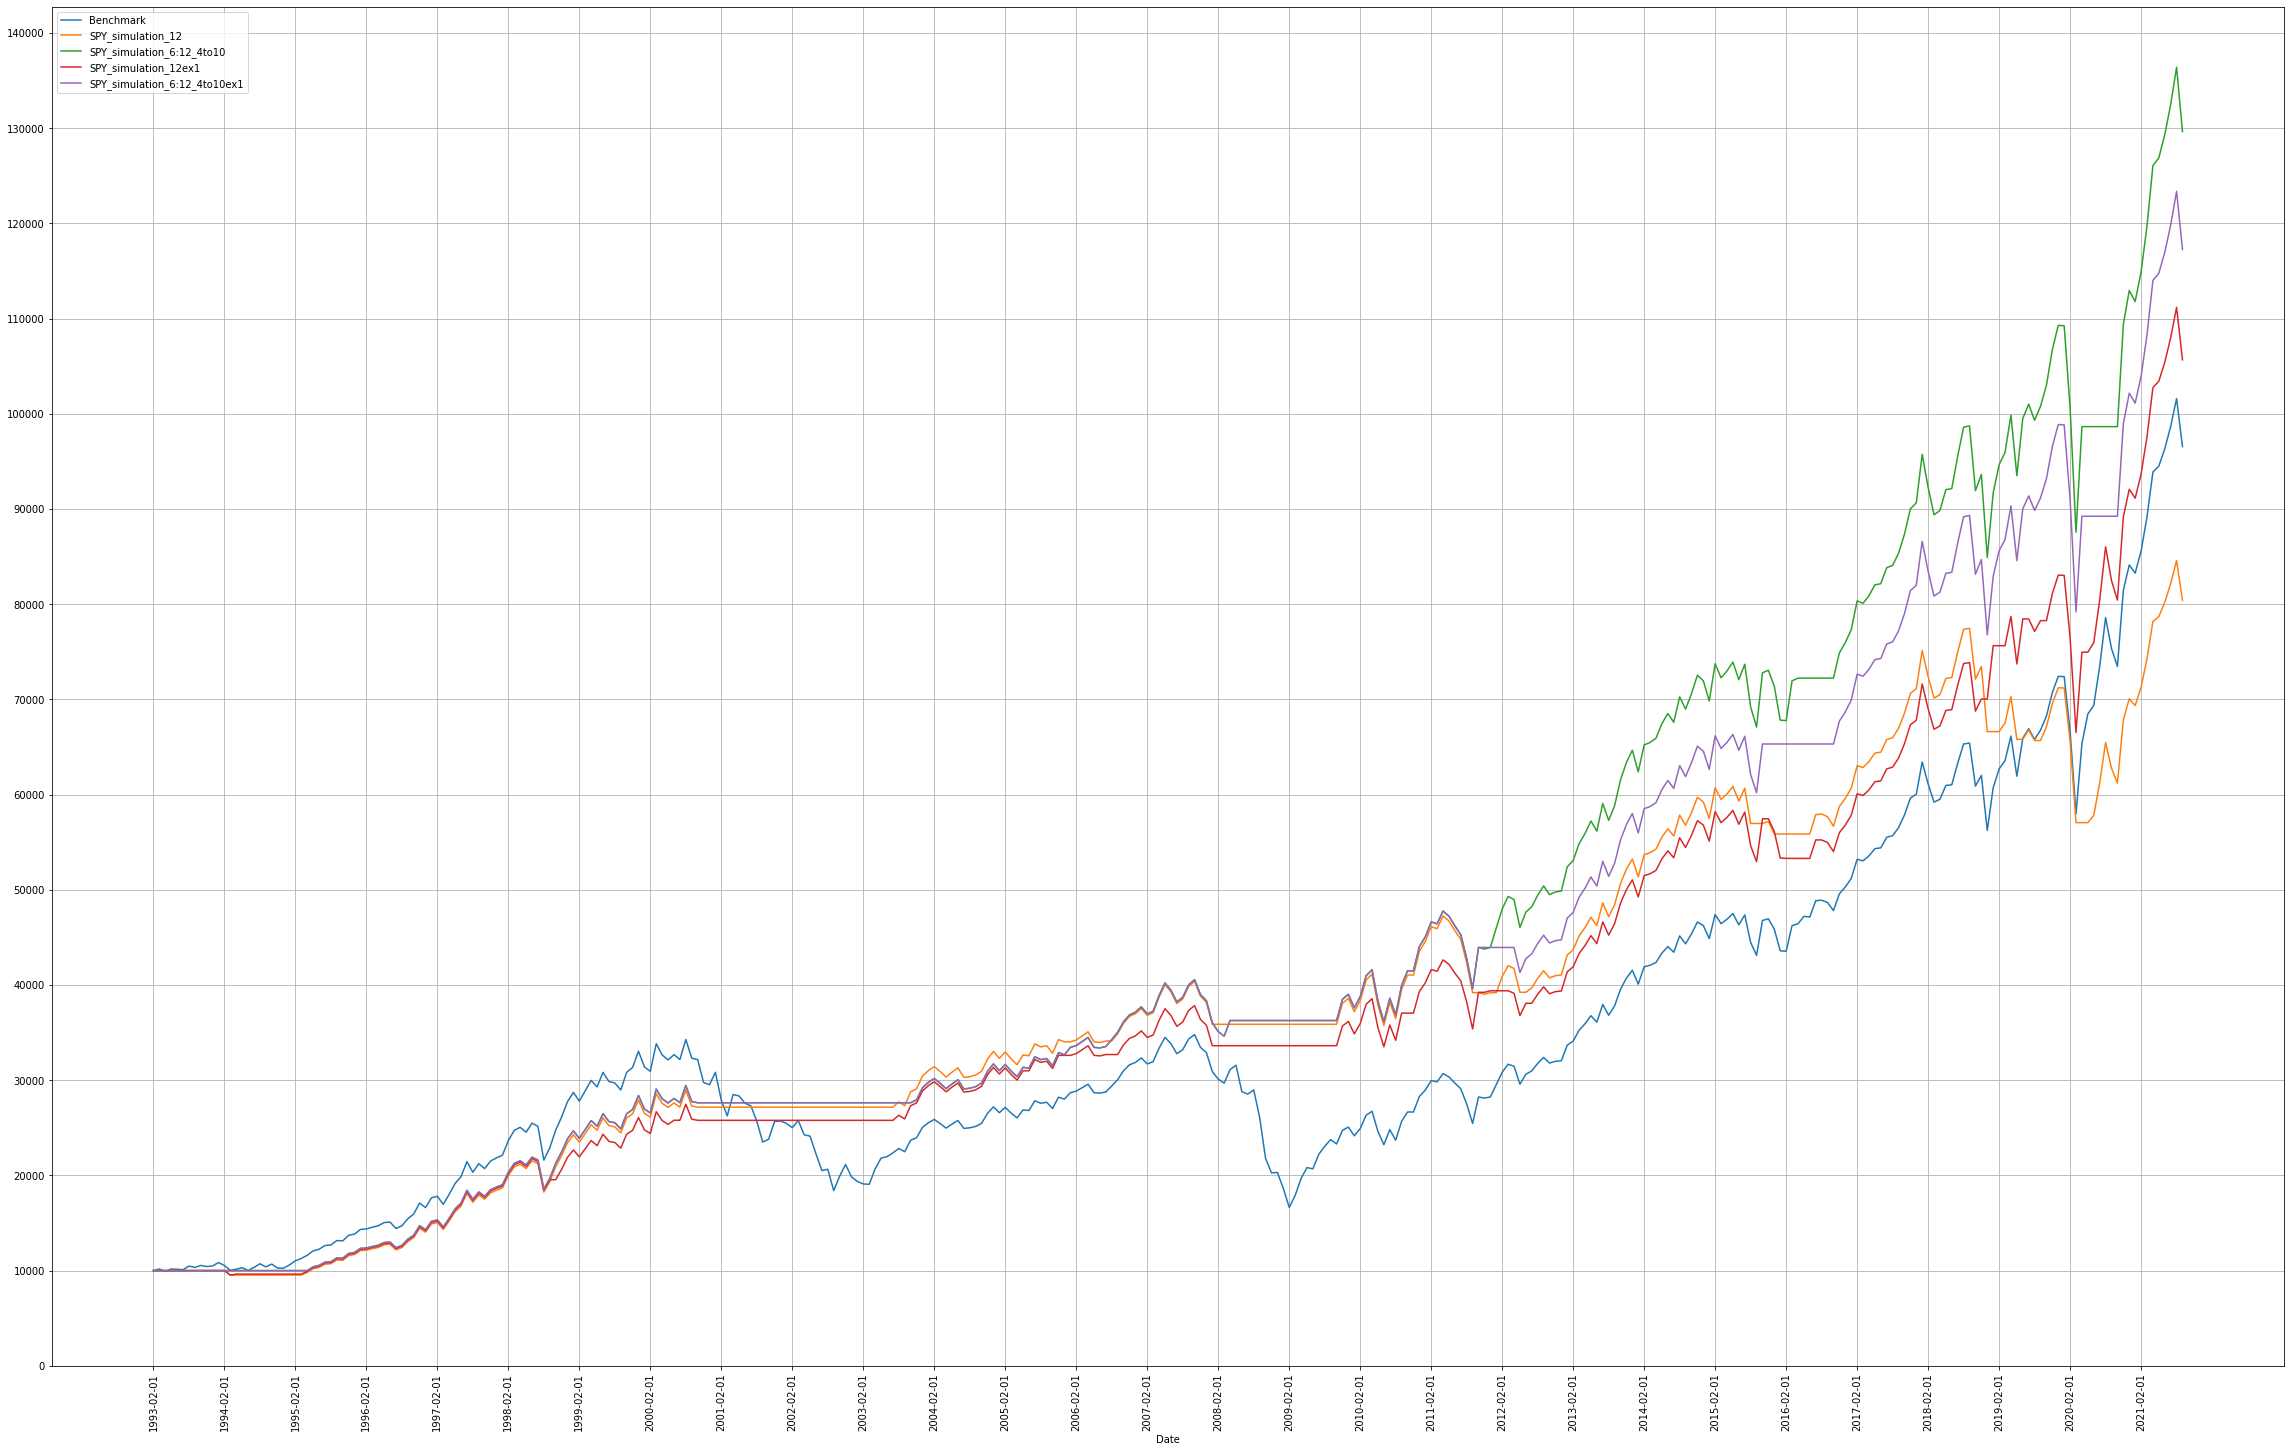

In [450]:
chart = returns_df.plot.line(x='Date', grid=True, figsize=(40,25), xticks=np.arange(0, 346, 12), yticks=np.arange(0, 150000, 10000))
chart.tick_params(axis='x', rotation=90)
chart.figure.savefig(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_returns.jpg')